<a href="https://colab.research.google.com/github/dennzii/kaggleCancerNotebooks/blob/main/densenet_training_dennzii_RSNA_MGMT_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RSNA MGMT DATASET - DenseNet121 ile 4 kanallı 3D Classification.  dennzii
---
DenseNet'in ResNet'den farkı tüm bloklar kendinden sonraki tüm bloklara residual bir bağlantı kurmasıdır.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import logging
import os
import sys
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

In [ ]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 1.8 MB/s eta 0:00:00


In [ ]:
#BratsPipelandan çıktı olarak alınan 4 modalite nifti başlıkları T1,T1C,FLAIR,T2 başlayacak şekilde rar'lanmış.
#Bunlar extract edilir.
path = "/content/data.rar"

import patoolib
os.makedirs("./data")
patoolib.extract_archive(path, outdir="/content/data")

INFO patool: Extracting /content/data.rar ...
INFO:patool:Extracting /content/data.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- /content/data.rar
INFO:patool:running /usr/bin/unrar x -kb -or -- /content/data.rar
INFO patool: ... /content/data.rar extracted to `/content/data'.
INFO:patool:... /content/data.rar extracted to `/content/data'.


'/content/data'

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd

labels_df = pd.read_csv("/content/data/train_labels.csv",dtype={'BraTS21ID':str})
labels_df


,BraTS21ID,MGMT_value
0,00000,1
1,00002,1
2,00003,0
3,00005,1
4,00006,1
...,...,...
580,01005,1
581,01007,1
582,01008,1
583,01009,0


In [ ]:
#monai yüklenir.
!pip install monai[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━

In [ ]:
dicom_dirs = os.listdir("/content/data/train")
dicom_dirs = [os.path.join("/content/data/train", dicom_dir) for dicom_dir in dicom_dirs]


In [ ]:
# Her bir dizin için birden fazla modaliteyi (kanalı) tanımlayın
import random
data_dicts = [{"img": os.path.join(dicom_dir,"T1w"),
               "label": labels_df.loc[labels_df['BraTS21ID'] == os.path.basename(dicom_dir), 'MGMT_value'].values[0]}
              for dicom_dir in dicom_dirs]
random.shuffle(data_dicts)

# Hastaların Imaging ve Label içeren dictionary'lerinin oluşturulması.

Dictionary yapısının kullanılmasının sebebi

## Setup environment

## Setup imports

In [ ]:

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ScaleIntensityd,
)

from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    ConcatItemsd,
    Identityd,
    Resized,
    RandRotate90d,
    DeleteItemsd,
    ScaleIntensity,
    ScaleIntensityRanged,
    CropForegroundd,
    RandRotated
)
from monai.data import Dataset, DataLoader
from monai.utils import first, set_determinism

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

MONAI version: 1.5.dev2512
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e4701e24c97d1f8c7ba40777c238cdfe14b04581
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.14.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.50.0
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io

In [ ]:
data_dicts = [{"img":"/content/data/F_Verio_1996033660_niftis/F_t1_se_tra.nii","label":0},
             {"img":"/content/data/F_Verio_2011147897_niftis/F_t1_se_tra.nii","label":0},
             {"img":"/content/data/F_Verio_2012057310 (sonra)_niftis/F_t1_se_tra.nii","label":0},
             {"img":"/content/data/F_Verio_2015082144_niftis/F_t1_se_tra.nii","label":1}]

In [ ]:
from monai.data import Dataset
import numpy as np
import nibabel as nib
import scipy
from skimage.transform import resize

class BrainNiftiCenterImageTrickDataset(Dataset):

  def __init__(self, data_dict, transform=None, img_size=256, num_slices=64,is_train = True):
      self.image_paths = [d["img"] for d in data_dict]
      self.labels = [d["label"] for d in data_dict]
      self.img_size = img_size
      self.num_slices = num_slices
      self.transform = transform

      self.data = data_dict


  def __len__(self):
      return len(self.labels)

  def __getitem__(self,idx):
      data_img_path = self.image_paths[idx]
      data_img_label = self.labels[idx]

      print(data_img_path)

      #done
      img3d = self.readNifti3D(data_img_path)

      # (H,W,D)'yi (C,H,W,D)'ye çevirir.
      img3d = np.expand_dims(img3d,axis=0)

      #transform dict ile çalıştığı için geçici bir dict tanımlanır.
      if self.transform:
        tmp_data = {"img":img3d}
        transformed = self.transform(tmp_data)
        img3d = transformed['img']

      return {"img":img3d,"label": torch.tensor(data_img_label,dtype=torch.float32)}


  def readNifti3D(self,nifti_path):

      img = nib.load(nifti_path).get_fdata()
      print(img.shape)
      img3d = img.astype(np.float32)



      #kesit sayısı
      total_slices_num = img3d.shape[-1]

      #ortanca kesit
      middle_num = total_slices_num // 2

      #ortanca kesitin etrafından bir yanından alınacak kesit sayısı
      # 64 kesit isteniyorsa 32 hesaplanır ve ortanca kesitin iki yanından 32 ve 31 kesit alınır
      # kesit sayısı böylece 64'e tamamlanır.
      num_slices_half = self.num_slices // 2

      start = max(0, middle_num - num_slices_half)
      end = min(total_slices_num, middle_num + num_slices_half)

      img3d = img3d[:,:,start:end]

      #ilk önce resize edilir sonra padding yapılır ki H,W boyutları uyuşsun.
      img3d = self.resize_slices(img3d, (self.img_size,self.img_size))

      #padding eklenir.
      if img3d.shape[-1] < self.num_slices:
          pad = np.zeros((self.img_size,self.img_size,self.num_slices - img3d.shape[-1]))
          img3d = np.concatenate((img3d,pad),axis=-1)


      return img3d

  def resize_slices(self,img3d, target_shape):

      h, w, d = img3d.shape

      resized = np.zeros((target_shape[0], target_shape[1], d), dtype=img3d.dtype)

      for i in range(d):
          # Her dilimi yeniden boyutlandır
          resized[:,:,i] = resize(img3d[:,:,i], target_shape, mode='constant', preserve_range=True, anti_aliasing=True)

      return resized





In [ ]:

from monai.data import Dataset, DataLoader

train_transform = Compose(
    [
        EnsureChannelFirstd(keys=["img"]),
        ScaleIntensityd(keys=['img']),
        ])

train_ds = BrainNiftiCenterImageTrickDataset(data_dict=data_dicts[:1]
                                          ,img_size= 256,num_slices=32,is_train=True)
val_ds = BrainNiftiCenterImageTrickDataset(data_dict=data_dicts[1:],
                                           img_size=256,num_slices=32,is_train=False)


train_loader = DataLoader(train_ds, batch_size=1, num_workers=2, pin_memory=True,drop_last=True)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=True,drop_last=True)



/content/data/F_Verio_2015082144_niftis/F_t1_se_tra.nii
(320, 320, 20)


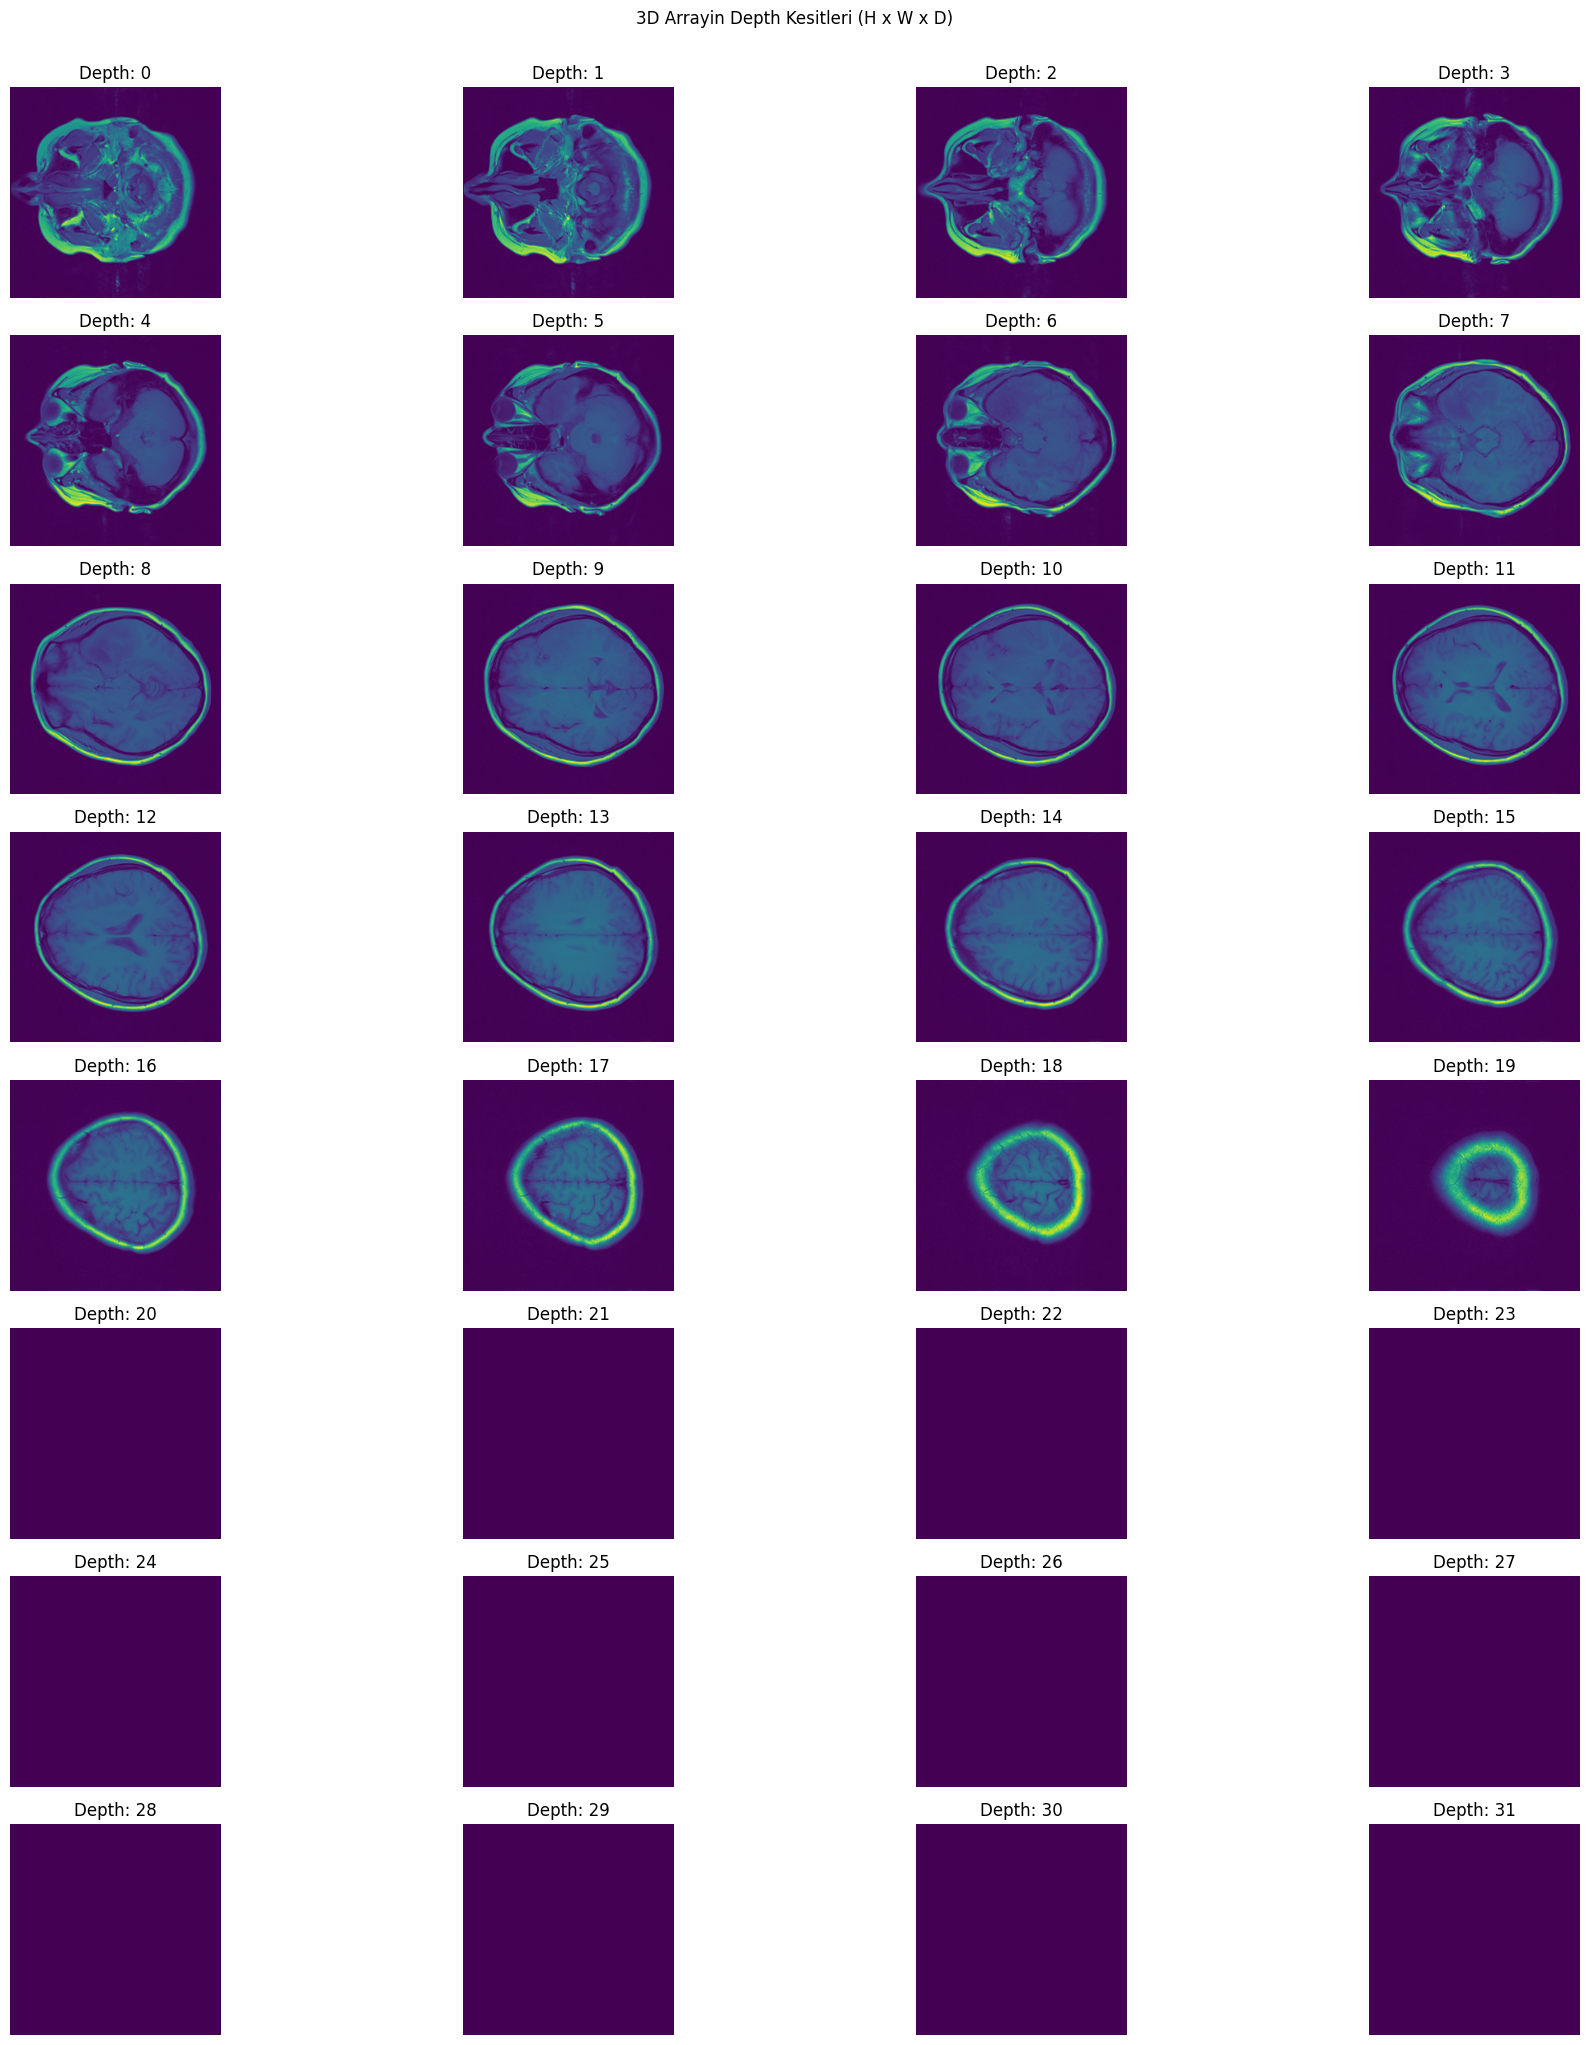

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


array_3d = val_ds[2]['img']
c,h,w,d  = array_3d.shape


plt.figure(figsize=(20, 20))

for depth in range(d):
    plt.subplot(8, 4, depth+1)
    plt.imshow(array_3d[0,:, :, depth], cmap='viridis')
    plt.title(f'Depth: {depth}')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('3D Arrayin Depth Kesitleri (H x W x D)', y=1.02)
plt.show()

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# **Volumes on different channels should has same affine matrices**
# Otherwise we get "RuntimeError: affine matrix of all images should be the same for channel-wise concatenation" error.

In [ ]:
import torch
import gc
from torch.utils.tensorboard import SummaryWriter
import monai
from torch.optim import lr_scheduler

# Training settings
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 45

gc.enable()
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model initialization
model = monai.networks.nets.resnet10(spatial_dims=3,
                                     n_input_channels=1,
                                     num_classes=1).to(device)

loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.5, last_epoch=-1)

def train_epoch(epoch, model, train_loader, optimizer, writer):
    model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0
    step = 0

    for batch_data in train_loader:

        step += 1
        inputs = batch_data['img'].to(device, non_blocking=True).float()
        labels = batch_data['label'].to(device, non_blocking=True).float().unsqueeze(1)  # Boyutu [batch_size, 1] yap
# BCE için float olmalı

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, labels)  # BCE Loss hesaplama

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Sigmoid sonrası 0.5 eşik değeri kullanarak doğruluk hesaplama
        with torch.no_grad():
            probs = torch.sigmoid(outputs)  # BCE için sigmoid uygula
            predictions = (probs > 0.5).float()  # 0.5 eşik değeriyle sınıflandır
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)

    torch.cuda.empty_cache()

    return epoch_loss / step, correct_train / total_train

def validate(model, val_loader):
    model.eval()
    num_correct = 0.0
    metric_count = 0

    with torch.no_grad():
        for val_data in val_loader:
            val_images = val_data['img'].to(device, non_blocking=True).float()
            val_labels = val_data['label'].to(device, non_blocking=True).float().unsqueeze(1)  # Boyutu [batch_size, 1] yap


            val_outputs = model(val_images)
            probs = torch.sigmoid(val_outputs)  # BCE için sigmoid uygula
            predictions = (probs > 0.5).float()  # 0.5 eşik değeriyle sınıflandır

            num_correct += (predictions == val_labels).sum().item()
            metric_count += len(val_labels)

            del val_images, val_labels, val_outputs, predictions
            torch.cuda.empty_cache()

    return num_correct / metric_count

# Training loop
try:
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")

        epoch_loss, train_accuracy = train_epoch(epoch, model, train_loader, optimizer, writer)
        epoch_loss_values.append(epoch_loss)

        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}, training accuracy: {train_accuracy:.4f}")
        writer.add_scalar("train_accuracy", train_accuracy, epoch + 1)

        scheduler.step()  # Öğrenme oranını güncelle

        if (epoch + 1) % val_interval == 0:
            metric = validate(model, val_loader)
            metric_values.append(metric)

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")

            print(f"Current epoch: {epoch+1} current accuracy: {metric:.4f}")
            print(f"Best accuracy: {best_metric:.4f} at epoch {best_metric_epoch}")
            writer.add_scalar("val_accuracy", metric, epoch + 1)

        torch.cuda.empty_cache()
        gc.collect()

except Exception as e:
    print(f"Training interrupted: {str(e)}")
    torch.save(model.state_dict(), "interrupted_checkpoint.pth")

finally:
    writer.close()
    print(f"Training completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


----------
epoch 1/45
/content/data/F_SymphonyVision_2017031497 (sonra)_niftis/F_t2_tirm_tra_dark-fluid.nii
(448, 512, 26)
epoch 1 average loss: 0.7062, training accuracy: 0.0000
----------
epoch 2/45
/content/data/F_SymphonyVision_2017031497 (sonra)_niftis/F_t2_tirm_tra_dark-fluid.nii
(448, 512, 26)
Training completed, best_metric: -1.0000 at epoch: -1


KeyboardInterrupt: 

# Occlusion sensitivity
One method for trying to visualise why the network made a given prediction is occlusion sensitivity. We occlude part of the image, and see how the probability of a given prediction changes. We then iterate over the image, moving the occluded portion as we go, and in doing so we build up a sensitivity map detailing which areas were the most important in making the decision.

#### Bounds
If we were to test the occlusion centred on all voxels in our image, we would have to do `torch.prod(im.shape) = 96^3 = ~1e6` predictions. We can use the bounding box to only to the estimations in a region of interest, for example over one slice.

To do this, we simply give the bounding box as `(minC,maxC,minD,maxD,minH,maxH,minW,maxW)`. We can use `-1` for any value to use its full extent (`0` and `im.shape-1` for min's and max's, respectively).

#### Output
The output image in this example will look fairly bad, since our network hasn't been trained for very long. Training for longer should improve the quality of the occlusion map.

In [ ]:
import torch
from monai.visualize.img2tensorboard import add_animated_gif
from monai.transforms import ScaleIntensity
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

def visualize_3d_to_gif(data_sample, writer, tag="medical_scan", modality_idx=0, frame_dim=2):
    """
    Create animated GIF visualization of 3D medical images using tensorboard

    Args:
        data_sample: Dictionary containing image data or direct tensor
        writer: SummaryWriter instance
        tag: Name for the visualization in tensorboard
        modality_idx: Index of the modality to visualize
        frame_dim: Dimension to use for animation frames (default 2 for axial view)
    """
    # Extract image data
    if isinstance(data_sample, dict):
        image = data_sample.get('img', None) or data_sample.get('img', None)
    else:
        image = data_sample

    if image is None:
        raise ValueError("No image data found in sample")

    # Convert to tensor if needed
    if not isinstance(image, torch.Tensor):
        image = torch.as_tensor(image)

    # Ensure 4D tensor (C, D, H, W)
    if len(image.shape) == 3:
        image = image.unsqueeze(0)

    # Select specific modality
    if image.shape[0] > 1:
        image = image[modality_idx:modality_idx+1]

    # Normalize image for visualization
    image = ScaleIntensity()(image)

    # Add animated gif to tensorboard
    add_animated_gif(writer, tag, image, frame_dim, self_normalizing=False)

# Example usage

# Initialize tensorboard writer
writer = SummaryWriter('runs/medical_visualization')

# Get a sample from your dataloader
sample = next(iter(train_loader))

# Create visualizations for each modality
modality_names = ['T1w', 'T1wCE', 'T2w', 'FLAIR']
for idx, name in enumerate(modality_names):
    visualize_3d_to_gif(
        data_dicts,
        writer,
        tag=f"scan_{name}",
        modality_idx=idx
    )

writer.close()


In [ ]:
# create a validation data loader
test_ds = ImageDataset(image_files=scan_paths[-16:], labels=labels[-16:], transform=val_transforms)
test_loader = DataLoader(val_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data['img'].to(device), test_data['label'].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

In [ ]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd,
    Spacingd, ScaleIntensityRanged, CropForegroundd
)
from monai.data import Dataset, DataLoader
from monai.visualize import matshow3d
from monai.utils import first



# Define the transformation pipeline
transform = Compose(
    [
        LoadImaged(keys=["img", "label"]),  # Ensure it is working with paths
        EnsureChannelFirstd(keys=["img", "label"]),
        Orientationd(keys=["img", "label"], axcodes="PLS"),
        Spacingd(keys=["img", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["img"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["img", "label"], source_key="img"),
    ]
)

# Load the dataset using the correct format for img and label
check_ds = Dataset(data=data_dicts, transform=transform)
check_loader = DataLoader(check_ds, batch_size=1)

# Fetch the first sample and check shapes
data = first(check_loader)
print(f"Image shape: {data['img'].shape}, Label shape: {data['label'].shape}")

# Visualize the 3D image using matshow3d
matshow3d(
    volume=data["img"],
    fig=None,
    title="Input Image",
    figsize=(100, 100),
    every_n=10,
    frame_dim=-1,
    show=True,
    cmap="gray",
)


In [ ]:
# Get a random image and its corresponding label
img, label = get_next_im()

In [ ]:
# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(nn_module=model, mask_size=12, n_batch=10)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2
occ_sens_b_box = [depth_slice - 1, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[0, label.argmax().item()][None]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor="white")

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = "gray" if i == 0 else "jet"
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis("off")
    fig.colorbar(im_show, ax=ax)

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)